In [1]:
# NumPy für numerische Berechnungen
import numpy as np  

# pandas zur Datenmanipulation und -analyse
import pandas as pd  

# matplotlib zur Visualisierung von Daten
import matplotlib.pyplot as plt  

# seaborn für erweiterte Visualisierung
import seaborn as sb  

# plotly für interaktive Visualisierungen (Graphenobjekte)
import plotly.graph_objs as go  

# plotly für interaktive Visualisierungen
import plotly  

# cufflinks für interaktive Visualisierungen von Pandas DataFrames
import cufflinks as cf  

# tqdm für Fortschrittsanzeigen in Schleifen
from tqdm import tqdm  

# StandardScaler zur Datennormalisierung und -kodierung
from sklearn.preprocessing import StandardScaler  

# metrics zur Auswertung von Modellen
from sklearn import metrics  

# XGBClassifier für XGBoost-Modelle
from xgboost import XGBClassifier  

# lightgbm für LightGBM-Modelle
import lightgbm as lgb  

# Konfiguration von Plotly für die Offline-Nutzung
plotly.offline.init_notebook_mode(connected=True)

# Konfiguration von cufflinks für die Offline-Nutzung
cf.set_config_file(offline=True)

# Unterdrücken von Warnmeldungen
import warnings
warnings.filterwarnings('ignore')

# Importieren von datetime für Datums- und Zeitoperationen
import datetime  



In [2]:
# Laden der Trainingsdaten
train = pd.read_csv('./data/train_features.csv')

# Anzeigen der Form der Trainingsdaten (Anzahl der Zeilen und Spalten)
train_shape = train.shape
print("Form der Trainingsdaten:", train_shape)

Form der Trainingsdaten: (1749494, 57)


In [3]:
# Anzeigen der ersten Zeilen der Trainingsdaten
train.head()

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,1,2016-01-01 00:00:00,NaN,0,0,Education,2720,104,0,19.4,...,4.116,3.981,4.146,4.12,3.569,4.489,4.079,3.554,3.538,3.845
1,32,2016-01-01 00:00:00,NaN,0,0,Office,48392,105,0,19.4,...,4.116,3.981,4.146,4.12,4.513,4.211,4.079,4.128,4.579,4.317
2,41,2016-01-01 00:00:00,NaN,0,0,Office,93860,68,0,19.4,...,4.116,3.981,4.146,4.12,4.108,4.211,4.079,4.103,4.140,4.114
3,55,2016-01-01 00:00:00,NaN,0,0,Office,16726,111,0,19.4,...,4.116,3.981,4.146,4.12,3.506,4.211,4.079,3.308,3.565,3.813
4,69,2016-01-01 00:00:00,NaN,0,0,Parking,387638,100,0,19.4,...,4.116,3.981,4.146,4.12,3.035,3.623,4.079,3.892,3.090,3.577


In [4]:
# Überprüfen und Anzeigen fehlender Werte in den Spalten der Trainingsdaten
for col in train.columns:
    missing_values = train[col].isnull().sum()
    if missing_values > 0:
        print(f"Anzahl fehlender Werte in Spalte '{col}': {missing_values}")


Anzahl fehlender Werte in Spalte 'meter_reading': 107653


In [5]:
# Durchlaufen aller eindeutigen Gebäude-IDs und Überprüfen der Anzahl der eindeutigen primären Nutzungen
for building_id in tqdm(train['building_id'].unique(), desc="Durchlaufe Gebäude-IDs"):
    
    # Wenn die Anzahl der eindeutigen primären Nutzungen größer als 1 ist, geben Sie die Gebäude-ID aus
    if train[train['building_id'] == building_id]['primary_use'].nunique() > 1:
        print("Mehrere primäre Nutzungen für Gebäude-ID:", building_id)


Durchlaufe Gebäude-IDs: 100%|█████████████████| 200/200 [00:02<00:00, 77.46it/s]


In [6]:
# Initialisierung von Listen für Integer-, Objekt- und Gleitkommazahlen-Spalten
integer = []
objects = []
floats = []

# Iteration über alle Spalten in den Trainingsdaten
for col in train.columns:
    
    # Überprüfung des Datentyps der aktuellen Spalte und Hinzufügen zur entsprechenden Liste
    if train[col].dtype == int:
        integer.append(col)
    elif train[col].dtype == object:
        objects.append(col)
    else:
        floats.append(col)

In [7]:
integer

['building_id',
 'anomaly',
 'site_id',
 'square_feet',
 'year_built',
 'floor_count',
 'cloud_coverage',
 'precip_depth_1_hr',
 'wind_direction',
 'hour',
 'weekday',
 'month',
 'year',
 'is_holiday']

In [8]:
# Anzeigen der Anzahl der eindeutigen Werte für Spalten vom Datentyp Integer
unique_counts_ints = train[integer].nunique()
print("Anzahl der eindeutigen Werte für Spalten vom Datentyp Integer:")
print(unique_counts_ints)

Anzahl der eindeutigen Werte für Spalten vom Datentyp Integer:
building_id          200
anomaly                2
site_id               14
square_feet          200
year_built            32
floor_count           12
cloud_coverage        11
precip_depth_1_hr    128
wind_direction        44
hour                  24
weekday                7
month                 12
year                   1
is_holiday             2
dtype: int64


In [9]:

year_built_counts = train['year_built'].value_counts()

# Anzeigen der Häufigkeit der Werte in der Spalte 'year_built'
print("Häufigkeit der Werte in der Spalte 'year_built':")
for index, count in year_built_counts.items():
    print(f"Jahr: {index}, Anzahl: {count}")

Häufigkeit der Werte in der Spalte 'year_built':
Jahr: 255, Anzahl: 1161101
Jahr: 76, Anzahl: 105408
Jahr: 66, Anzahl: 70271
Jahr: 19, Anzahl: 43920
Jahr: 60, Anzahl: 43919
Jahr: 110, Anzahl: 35058
Jahr: 114, Anzahl: 26345
Jahr: 105, Anzahl: 17568
Jahr: 104, Anzahl: 17568
Jahr: 68, Anzahl: 17567
Jahr: 67, Anzahl: 17566
Jahr: 64, Anzahl: 17564
Jahr: 9, Anzahl: 8784
Jahr: 77, Anzahl: 8784
Jahr: 13, Anzahl: 8784
Jahr: 45, Anzahl: 8784
Jahr: 100, Anzahl: 8784
Jahr: 74, Anzahl: 8784
Jahr: 0, Anzahl: 8784
Jahr: 6, Anzahl: 8784
Jahr: 107, Anzahl: 8784
Jahr: 103, Anzahl: 8784
Jahr: 111, Anzahl: 8784
Jahr: 31, Anzahl: 8783
Jahr: 89, Anzahl: 8783
Jahr: 70, Anzahl: 8782
Jahr: 82, Anzahl: 8782
Jahr: 57, Anzahl: 8781
Jahr: 65, Anzahl: 8781
Jahr: 92, Anzahl: 8781
Jahr: 52, Anzahl: 8781
Jahr: 30, Anzahl: 8761


In [10]:
# Anzeigen der Häufigkeit der Werte in der Spalte 'cloud_coverage'
cloud_coverage_counts = train['cloud_coverage'].value_counts()

# Formatieren und Ausgeben der Häufigkeitszählungen
print("Häufigkeit der Werte in der Spalte 'cloud_coverage':")
for index, count in cloud_coverage_counts.items():
    print(f"Wolkenabdeckung: {index}, Anzahl: {count}")


Häufigkeit der Werte in der Spalte 'cloud_coverage':
Wolkenabdeckung: 255, Anzahl: 797545
Wolkenabdeckung: 0, Anzahl: 622994
Wolkenabdeckung: 2, Anzahl: 155730
Wolkenabdeckung: 4, Anzahl: 111173
Wolkenabdeckung: 6, Anzahl: 26337
Wolkenabdeckung: 8, Anzahl: 22152
Wolkenabdeckung: 9, Anzahl: 8231
Wolkenabdeckung: 7, Anzahl: 3485
Wolkenabdeckung: 1, Anzahl: 713
Wolkenabdeckung: 3, Anzahl: 608
Wolkenabdeckung: 5, Anzahl: 526


In [11]:
# Ersetzen von Ausreißerwerten (255) in der Spalte 'cloud_coverage' durch den Wert 10,
# um die Daten zu bereinigen und die Analyse zu verbessern
train['cloud_coverage'] = train['cloud_coverage'].replace({255: 10})

# Anzeigen der ersten Zeilen der aktualisierten Trainingsdaten, nur mit der Spalte 'cloud_coverage'
print("Aktualisierte Trainingsdaten mit bereinigter 'cloud_coverage' Spalte:")
train[['cloud_coverage']].head()





Aktualisierte Trainingsdaten mit bereinigter 'cloud_coverage' Spalte:


,cloud_coverage
0,10
1,10
2,10
3,10
4,10


In [12]:
# Konvertieren der Spalte 'timestamp' in ein Datum und Zuweisen an die neue Spalte 'date'
train['date'] = pd.to_datetime(train['timestamp']).dt.date

# Gruppieren nach 'building_id' und 'date', dann Berechnen der Standardabweichung der täglichen Meterablesungen
grouped = train.groupby(['building_id', 'date'])
meter_reading_std = grouped['meter_reading'].transform('std')

# Zuweisen der berechneten Standardabweichung an die neue Spalte 'meterReadings_daily_std'
train['meterReadings_daily_std'] = meter_reading_std

In [13]:
# Entfernen der Spalten 'timestamp', 'year' und 'gte_meter' aus den Trainingsdaten
train = train.drop(['timestamp', 'year', 'gte_meter'], axis=1)


In [14]:
# Entfernen der Spalten ab dem dritten Objekt in der Liste 'objects' aus den Trainingsdaten
train = train.drop(objects[2:], axis=1)

# Anzeigen der neuen Form der Trainingsdaten
print("Neue Form der Trainingsdaten:", train.shape)


Neue Form der Trainingsdaten: (1749494, 50)


In [15]:
floats

['meter_reading',
 'air_temperature',
 'dew_temperature',
 'sea_level_pressure',
 'wind_speed',
 'air_temperature_mean_lag7',
 'air_temperature_max_lag7',
 'air_temperature_min_lag7',
 'air_temperature_std_lag7',
 'air_temperature_mean_lag73',
 'air_temperature_max_lag73',
 'air_temperature_min_lag73',
 'air_temperature_std_lag73',
 'hour_x',
 'hour_y',
 'month_x',
 'month_y',
 'weekday_x',
 'weekday_y',
 'gte_hour',
 'gte_weekday',
 'gte_month',
 'gte_building_id',
 'gte_primary_use',
 'gte_site_id',
 'gte_meter',
 'gte_meter_hour',
 'gte_meter_weekday',
 'gte_meter_month',
 'gte_meter_building_id',
 'gte_meter_primary_use',
 'gte_meter_site_id',
 'gte_meter_building_id_hour',
 'gte_meter_building_id_weekday',
 'gte_meter_building_id_month']

In [16]:
def fill_null_meter_readings(data):
    """
    Funktion zum Auffüllen von Nullwerten in der Spalte 'meter_reading' basierend auf dem durchschnittlichen Wert
    für jede 'building_id'.

    Argumente:
    data : Die Eingabedaten, die bearbeitet werden sollen.

    Returns:
    DataFrame: Die aktualisierten Daten mit den aufgefüllten Nullwerten.
    """
    # Berechnen des durchschnittlichen Meterwerts für jede building_id
    mean_reading = data.groupby('building_id')['meter_reading'].mean()

    # Iteration über jede building_id
    for building_id, mean_value in tqdm(mean_reading.items(), desc="Auffüllen von Nullwerten"):
        # Ersetzen von NaN-Werten in meter_reading durch den Durchschnittswert für die entsprechende building_id
        data.loc[data['building_id'] == building_id, 'meter_reading'] = data.loc[data['building_id'] == building_id, 'meter_reading'].fillna(mean_value)
    
    return data

# Anwenden der Imputationsfunktion auf das train DataFrame
train = fill_null_meter_readings(train)



Auffüllen von Nullwerten: 200it [00:01, 170.75it/s]


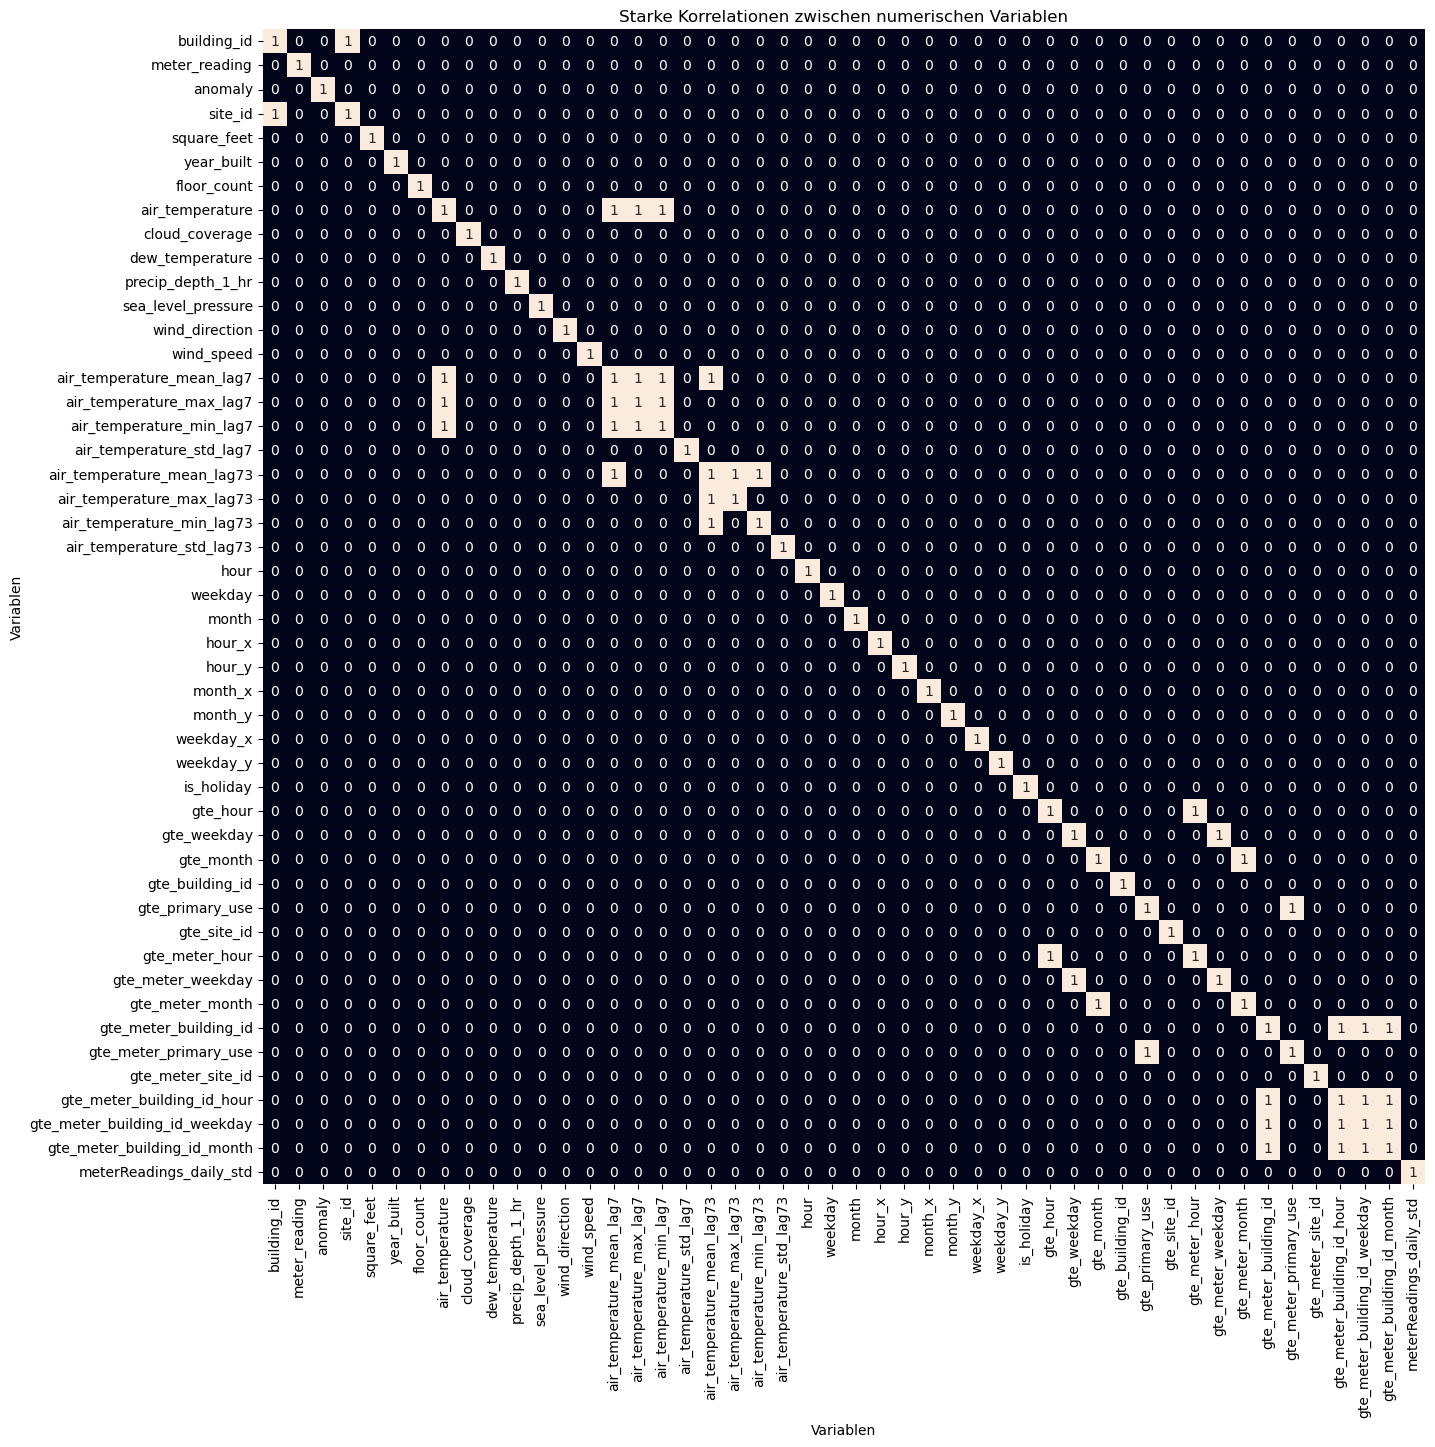

In [17]:
# Untersuchung starker Korrelationen zwischen numerischen Variablen

# Wenn zwei Dinge stark miteinander zusammenhängen, sagen wir, dass sie "korreliert" sind. 
# In unseren Daten schauen wir uns an, ob bestimmte Zahlen, die wir über Gebäude wissen, zusammenhängen, wie zum Beispiel das Baujahr und die Anzahl der Stockwerke. 

# Eine Heatmap ist wie ein farbiges Bild unserer Daten. Sie zeigt, wie stark verschiedene Zahlen in unseren Daten zusammenhängen. 
# Wenn zwei Zahlen sehr zusammenhängen, wird die Zelle in der Heatmap mit einer Farbe markiert. 

# Wir schauen uns die Zahlen nur für Dinge an, die mit Gebäuden zu tun haben, wie zum Beispiel das Baujahr oder die Anzahl der Stockwerke.
# Dann malen wir die Heatmap und schauen uns an, ob es Bereiche gibt, in denen die Zahlen besonders stark zusammenhängen. 

# Wir wollen diese starken Zusammenhänge herausfinden, weil sie uns helfen können, die Daten besser zu verstehen und Muster zu erkennen.
# Das kann uns dann dabei helfen, Modelle zu bauen, die uns mehr über die Gebäude in unseren Daten sagen.

numeric_columns = train.select_dtypes(include=[np.number])

# Erstellen einer Heatmap zur Visualisierung von stark korrelierten Variablen
plt.figure(figsize=(15,15))
sb.heatmap(numeric_columns.corr() > 0.95, annot=True, cbar=False)
plt.title('Starke Korrelationen zwischen numerischen Variablen')
plt.xlabel('Variablen')
plt.ylabel('Variablen')
plt.show()



In [18]:
# Zu entfernende Spalten für die Korrelationsanalyse
columns_to_remove = ['primary_use',
                     'gte_meter_hour',
                     'gte_meter_weekday',
                     'gte_meter_month',
                     'gte_meter_building_id',
                     'gte_meter_primary_use',
                     'gte_meter_site_id',
                     'gte_meter_building_id_hour',
                     'gte_meter_building_id_weekday',
                     'gte_meter_building_id_month',
                     'air_temperature_mean_lag73',
                     'air_temperature_max_lag73',
                     'air_temperature_min_lag73',
                     'air_temperature_mean_lag7',
                     'air_temperature_max_lag7',
                     'air_temperature_min_lag7']

# Entfernen der ausgewählten Spalten aus den Trainingsdaten, falls vorhanden
if set(columns_to_remove).issubset(train.columns):
    train = train.drop(columns_to_remove, axis=1)
    print("Die ausgewählten Spalten wurden erfolgreich aus den Trainingsdaten entfernt.")
else:
    print("Die ausgewählten Spalten wurden bereits aus den Trainingsdaten entfernt oder sind nicht vorhanden.")

# Anzeigen der neuen Form der Trainingsdaten
print("Neue Form der Trainingsdaten:", train.shape)


Die ausgewählten Spalten wurden erfolgreich aus den Trainingsdaten entfernt.
Neue Form der Trainingsdaten: (1749494, 34)


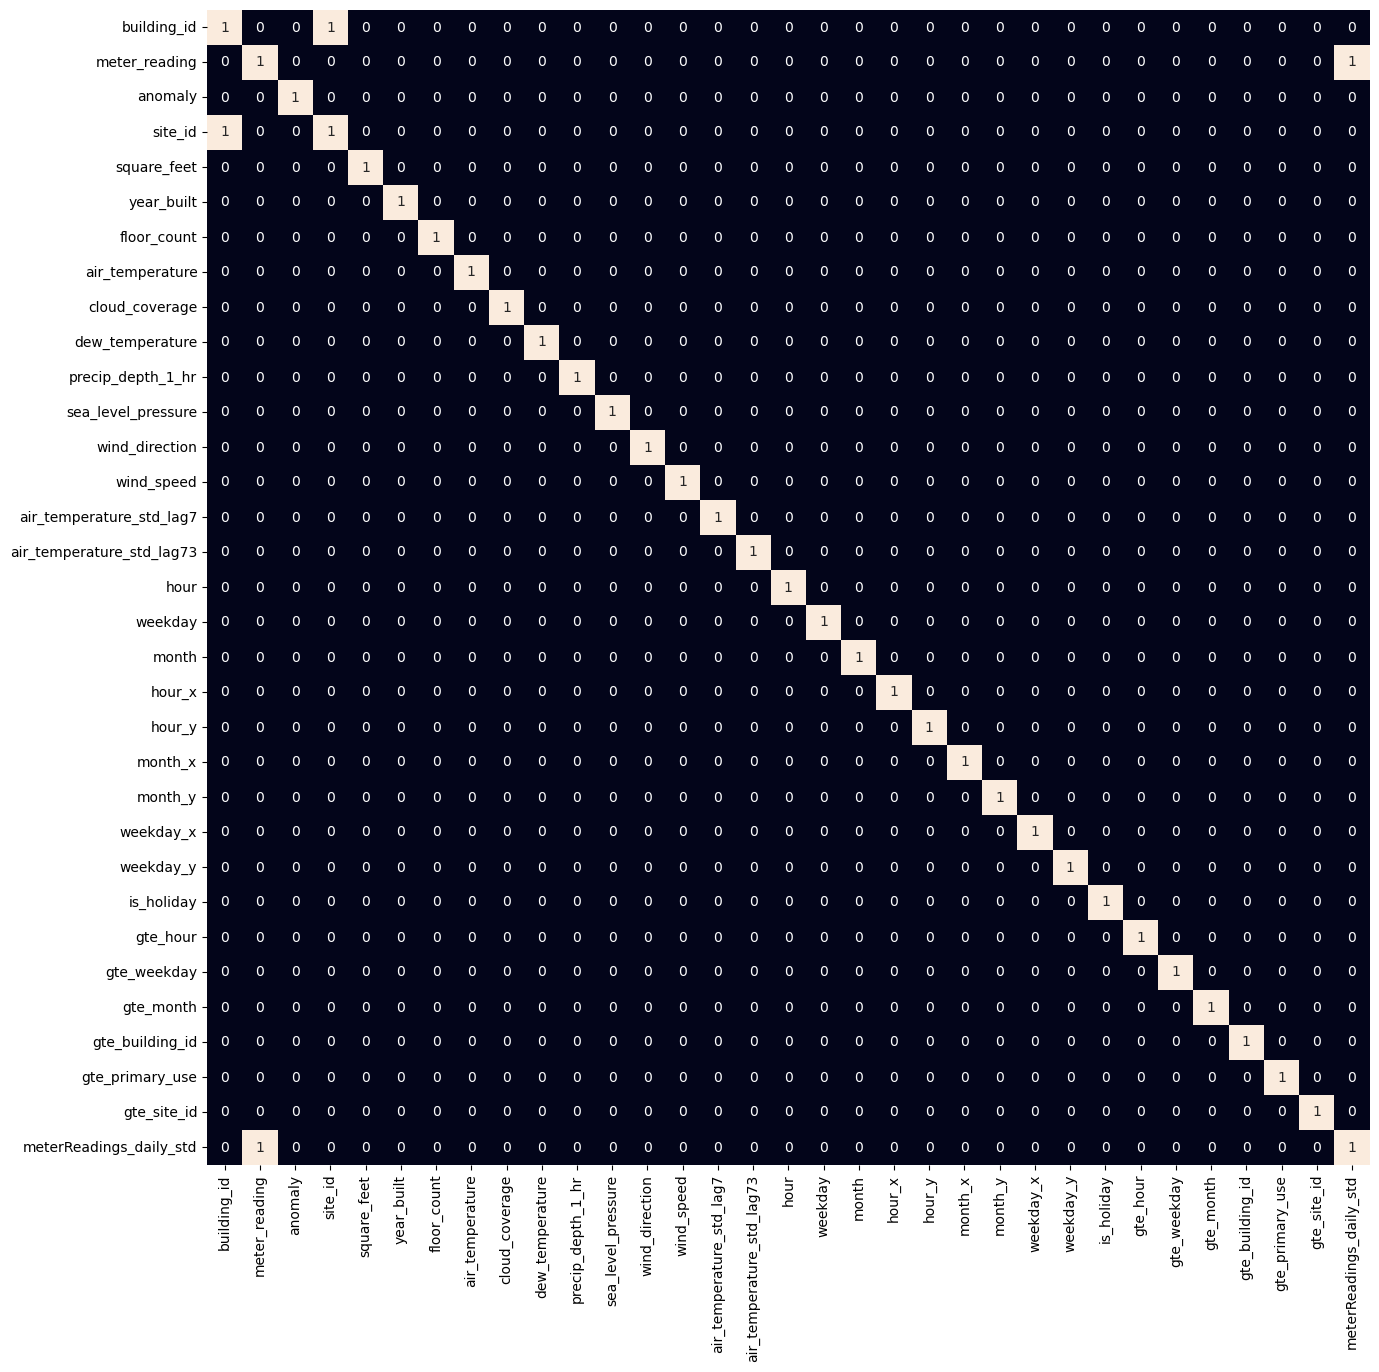

In [19]:
# Ausgrenzen von Spalten mit datetime.date-Objekten, da diese nicht für die Korrelationsanalyse geeignet sind
numeric_columns = train.select_dtypes(include=[np.number])

# Eine weitere Heatmap wird erstellt, um starke Korrelationen zwischen numerischen Variablen zu visualisieren.
# Diesmal betrachten wir nur Korrelationen, die größer als 0,75 sind. Das bedeutet, dass Variablen mit einer Korrelation über 0,75 als stark korreliert angesehen werden.
plt.figure(figsize=(15, 15))
sb.heatmap(numeric_columns.corr() > 0.75, annot=True, cbar=False)
plt.show()


In [20]:
# Lese Testdaten aus einer CSV-Datei ein und setze den Index auf die erste Spalte
test = pd.read_csv('./data/test_features.csv', index_col=0)

# Führe die Funktion zur Auffüllung von Nullwerten auf den Testdaten aus
test = fill_null_meter_readings(test)

# Ersetze den Wert 255 in der Spalte 'cloud_coverage' durch 10
test['cloud_coverage'] = test['cloud_coverage'].replace({255: 10})

# Konvertiere die 'timestamp'-Spalte in ein Datum und weise sie der 'date'-Spalte zu
test['date'] = pd.to_datetime(test['timestamp']).dt.date

# Berechne die Standardabweichung der täglichen Meterablesungen für jedes Gebäude und Datum
# und füge sie der 'meterReadings_daily_std'-Spalte hinzu
test['meterReadings_daily_std'] = test.groupby(['building_id', 'date'])['meter_reading'].transform('std')

# Entferne die unerwünschten Spalten aus den Testdaten
columns_to_remove = ['timestamp', 'year', 'gte_meter'] + objects[2:] + columns_to_remove
test = test.drop(columns_to_remove, axis=1)


Auffüllen von Nullwerten: 206it [00:01, 178.09it/s]


In [21]:
# Lese Trainingsdaten aus einer CSV-Datei ein
train_feature = pd.read_csv('./data/train_features.csv')

# Iteriere über verschiedene Zeitschichten für Verschiebungen und zeige den Fortschritt an
for shift_hours in tqdm([-1, 1, -24, 24, -7*24, 7*24]):
    # Erstelle eine Kopie des DataFrame mit den relevanten Spalten für die Verschiebung
    meter_reading_shift = train_feature[['building_id', 'timestamp', 'meter_reading']]
    
    # Füge die Stundenverschiebung zur 'timestamp'-Spalte hinzu, um Verschiebungen zu simulieren
    meter_reading_shift['timestamp'] = pd.to_datetime(meter_reading_shift['timestamp']) + datetime.timedelta(hours=shift_hours)
    
    # Konvertiere die 'timestamp'-Spalte in einen String, um sie für den Join verwenden zu können
    meter_reading_shift['timestamp'] = meter_reading_shift['timestamp'].astype('str')
    
    # Umbenenne die 'meter_reading'-Spalte in 'lag_value_'+str(shift_hours) für die Verschiebung
    meter_reading_shift = meter_reading_shift.rename(columns={'meter_reading':'lag_value_'+str(shift_hours)})
    
    # Führe einen linken Join mit dem ursprünglichen Trainingsdaten durch, um die Verschiebungen hinzuzufügen
    train_feature = train_feature.merge(meter_reading_shift, on=['building_id', 'timestamp'], how='left')
    
    # Berechne die Differenz zwischen der ursprünglichen 'meter_reading'-Spalte und der verschobenen Spalte,
    # um die Veränderung der Werte durch die Verschiebung zu erfassen
    train['lag_value_'+str(shift_hours)] = train_feature['lag_value_'+str(shift_hours)] - train_feature['meter_reading']

    

100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.24s/it]


In [22]:
# Lese Testdaten aus einer CSV-Datei ein
test_feature = pd.read_csv('./data/test_features.csv')

# Definiere eine Funktion, um Meterablesungen zu verschieben
def shift_meter_readings(test_feature, shift_hours):
    # Erstelle eine Kopie des DataFrame mit den relevanten Spalten für die Verschiebung
    meter_reading_shift = test_feature[['building_id', 'timestamp', 'meter_reading']]
    
    # Füge die Stundenverschiebung zur 'timestamp'-Spalte hinzu
    meter_reading_shift['timestamp'] = pd.to_datetime(meter_reading_shift['timestamp']) + datetime.timedelta(hours=shift_hours)
    
    # Konvertiere die 'timestamp'-Spalte in einen String
    meter_reading_shift['timestamp'] = meter_reading_shift['timestamp'].astype('str')
    
    # Umbenenne die 'meter_reading'-Spalte in 'lag_value_'+str(shift_hours) für die Verschiebung
    meter_reading_shift = meter_reading_shift.rename(columns={'meter_reading':'lag_value_'+str(shift_hours)})
    
    return meter_reading_shift

# Iteriere über Verschiebungsstunden und wende die Funktion an
for shift_hours in tqdm([-1, 1, -24, 24, -7*24, 7*24]):
    meter_reading_shift = shift_meter_readings(test_feature, shift_hours)
    test_feature = pd.merge(test_feature, meter_reading_shift, on=['building_id', 'timestamp'], how='left')
    
    # Berechne die Differenz zwischen der ursprünglichen 'meter_reading'-Spalte und der verschobenen Spalte
    # um die Veränderung der Werte durch die Verschiebung zu erfassen
    test['lag_value_'+str(shift_hours)] = test_feature['lag_value_'+str(shift_hours)] - test_feature['meter_reading']


100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.45s/it]


In [23]:
# Beschreibung der Testdaten, um statistische Kennzahlen zu erhalten
test.describe()

,building_id,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,...,gte_building_id,gte_primary_use,gte_site_id,meterReadings_daily_std,lag_value_-1,lag_value_1,lag_value_-24,lag_value_24,lag_value_-168,lag_value_168
count,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,1.800567e+06,...,1.800567e+06,1.800567e+06,1.800567e+06,1.800561e+06,1.701485e+06,1.701485e+06,1.687819e+06,1.687819e+06,1.640499e+06,1.640499e+06
mean,8.040281e+02,1.759617e+02,7.912157e+00,1.019317e+05,1.953569e+02,8.537594e-01,1.651532e+01,5.176040e+00,8.779221e+00,1.255604e-01,...,4.278809e+00,4.378195e+00,4.402207e+00,2.336211e+01,2.586809e-02,-2.586809e-02,-3.055578e-02,3.055578e-02,-3.693871e-01,3.693871e-01
std,4.130023e+02,2.836115e+02,4.861850e+00,1.203122e+05,8.709273e+01,2.095721e+00,1.032139e+01,4.618847e+00,9.885269e+00,6.075749e+00,...,1.520180e+00,3.490425e-01,7.518568e-01,1.001854e+02,9.407798e+01,9.407798e+01,1.309355e+02,1.309355e+02,1.501181e+02,1.501181e+02
min,1.800000e+01,0.000000e+00,0.000000e+00,1.102000e+03,4.000000e+00,0.000000e+00,-2.990000e+01,0.000000e+00,-3.600000e+01,-2.000000e+00,...,8.900000e-01,2.929000e+00,2.670000e+00,0.000000e+00,-7.833700e+04,-3.192000e+04,-7.833500e+04,-7.976800e+04,-7.838000e+04,-7.838900e+04
25%,4.760000e+02,2.500000e+01,3.000000e+00,2.836300e+04,8.900000e+01,0.000000e+00,9.000000e+00,0.000000e+00,1.700000e+00,-1.000000e+00,...,3.278000e+00,4.342000e+00,4.174000e+00,3.523174e+00,-2.347000e+00,-2.000000e+00,-4.020000e+00,-3.601500e+00,-4.481000e+00,-4.157000e+00
50%,9.180000e+02,7.140000e+01,9.000000e+00,5.819600e+04,2.550000e+02,0.000000e+00,1.670000e+01,4.000000e+00,9.400000e+00,0.000000e+00,...,4.195000e+00,4.342000e+00,4.710000e+00,1.080462e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.223000e+03,2.017100e+02,1.400000e+01,1.305770e+05,2.550000e+02,0.000000e+00,2.440000e+01,1.000000e+01,1.670000e+01,0.000000e+00,...,5.431000e+00,4.615000e+00,4.744000e+00,2.892506e+01,2.000000e+00,2.347000e+00,3.601500e+00,4.020000e+00,4.157000e+00,4.481000e+00
max,1.425000e+03,7.976900e+04,1.500000e+01,8.503540e+05,2.550000e+02,1.300000e+01,4.720000e+01,1.000000e+01,2.610000e+01,3.430000e+02,...,7.802000e+00,5.359000e+00,5.148000e+00,1.690544e+04,3.192000e+04,7.833700e+04,7.976800e+04,7.833500e+04,7.838900e+04,7.838000e+04


In [24]:
# Entferne die 'date'- und 'meterReadings_daily_std'-Spalten aus den Trainingsdaten
train = train.drop(['date', 'meterReadings_daily_std'], axis=1)

# Entferne die 'date'- und 'meterReadings_daily_std'-Spalten aus den Testdaten
test = test.drop(['date', 'meterReadings_daily_std'], axis=1)


In [25]:
# Drucke die Form (Anzahl der Zeilen und Spalten) der Trainings- und Testdaten
print("Form der Trainingsdaten:", train.shape)
print("Form der Testdaten:", test.shape)


Form der Trainingsdaten: (1749494, 38)
Form der Testdaten: (1800567, 37)


In [26]:
# Unterteile den Trainingsdatensatz in negative (ohne Anomalien) und positive (mit Anomalien) Fälle
negatives = train[train['anomaly'] == 0]
positives = train[train['anomaly'] == 1]

# Drucke die Form (Anzahl der Zeilen und Spalten) der negativen und positiven Fälle
print("Form der negativen Fälle:", negatives.shape)
print("Form der positiven Fälle:", positives.shape)

# Zufällige Auswahl einer gleichen Anzahl von negativen Fällen für die Ausgleichung
negatives1 = negatives.sample(n=37296, random_state=10)
negatives2 = negatives.sample(n=37296, random_state=20)

# Kombiniere die ausgewählten negativen Fälle, positive Fälle und ausgewählte negative Fälle erneut
df_balanced = pd.concat([negatives1, positives, negatives2, positives], axis=0)

# Drucke die Form (Anzahl der Zeilen und Spalten) des ausgeglichenen Datensatzes
print("Form des ausgeglichenen Datensatzes:", df_balanced.shape)


Form der negativen Fälle: (1712198, 38)
Form der positiven Fälle: (37296, 38)
Form des ausgeglichenen Datensatzes: (149184, 38)


In [27]:
# Definiere die Features (unabhängige Variablen) als alle Spalten außer 'anomaly'
features = df_balanced.drop(['anomaly'], axis=1)

# Definiere das Target (abhängige Variable) als die 'anomaly'-Spalte
target = df_balanced['anomaly']


In [28]:
# Trennung der Trainings- und Validierungsdaten basierend auf Gebäude-ID

# Definiere die Trainingsfeatures (X_train) und die Validierungsfeatures (X_val) für Gebäude mit IDs, die bei der Division durch 5 einen Rest < 4 haben
X_train = features[train_feature['building_id'] % 7 < 3]
X_val = features[train_feature['building_id'] % 7 == 3]

# Definiere die Trainingszielvariablen (Y_train) und die Validierungszielvariablen (Y_val) entsprechend den ausgewählten Trainings- und Validierungsfeatures
Y_train = target[train_feature['building_id'] % 7 < 3]
Y_val = target[train_feature['building_id'] % 7 == 3]

# Drucke die Form (Anzahl der Zeilen und Spalten) der Trainings- und Validierungsfeatures
print("Form der Trainingsfeatures und Validierungsfeatures:", X_train.shape, X_val.shape)


Form der Trainingsfeatures und Validierungsfeatures: (74910, 37) (17713, 37)


In [29]:
# Initialisierung des StandardScaler-Objekts
scaler = StandardScaler()

# Skalierung der Trainingsfeatures
X_train_scaled = scaler.fit_transform(X_train)

# Skalierung der Validierungsfeatures
X_val_scaled = scaler.transform(X_val)

# Skalierung der Testfeatures
test_scaled = scaler.transform(test)


In [30]:
# Initialisierung der Modelle
models = [XGBClassifier(), lgb.LGBMClassifier()]

# Iteration über die Modelle
for model in models:
    # Anpassung des aktuellen Modells an die Trainingsdaten
    model.fit(X_train_scaled, Y_train)

    # Druck der Modellinformationen
    # Druck der Modellmetriken
    print(f'Modell: {model.__class__.__name__}')
    print('Training Accuracy:', metrics.roc_auc_score(Y_train, model.predict_proba(X_train_scaled)[:,1]))
    print('Validation Accuracy:', metrics.roc_auc_score(Y_val, model.predict_proba(X_val_scaled)[:,1]))
    



Modell: XGBClassifier
Training Accuracy: 0.999958949018908
Validation Accuracy: 0.933092774049719
[LightGBM] [Info] Number of positive: 36882, number of negative: 38028
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4312
[LightGBM] [Info] Number of data points in the train set: 74910, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492351 -> initscore=-0.030599
[LightGBM] [Info] Start training from score -0.030599
Modell: LGBMClassifier
Training Accuracy: 0.9977706143045746
Validation Accuracy: 0.942859958825812


In [31]:
# Skalierung aller Features
X_all_scaled = scaler.transform(features)

In [32]:
# Anpassung des XGBClassifier-Modells an alle Features und Vorhersage der Wahrscheinlichkeiten für das Testdatenset
models[0].fit(X_all_scaled, target)
predictions_xgb = models[0].predict_proba(test_scaled)[:, 1]

# Anpassung des LGBMClassifier-Modells an alle Features und Vorhersage der Wahrscheinlichkeiten für das Testdatenset
models[1].fit(X_all_scaled, target)
predictions_lgb = models[1].predict_proba(test_scaled)[:, 1]


[LightGBM] [Info] Number of positive: 74592, number of negative: 74592
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4650
[LightGBM] [Info] Number of data points in the train set: 149184, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [33]:
# Lese die Beispielabgabe ein
sample_submission = pd.read_csv('./data/sample_submission.csv')

# Berechne den Durchschnitt der Vorhersagen beider Modelle und weise sie der 'anomaly'-Spalte zu
sample_submission['anomaly'] = (predictions_xgb + predictions_lgb) / 2

# Speichere die kombinierte Vorhersage als CSV-Datei
sample_submission.to_csv('./data/Submission_ensemble.csv', index=False)

In [34]:
# Aktualisieren der 'anomaly'-Spalte für Zeilen mit einem Meterwert von 1.0 auf 1
sample_submission.loc[test['meter_reading'] == 1.0, 'anomaly'] = 1

# Speichern der aktualisierten Daten in eine CSV-Datei
sample_submission.to_csv('Submission_ensemble_fixed.csv', index=False)

# Anzeigen der ersten Zeilen des aktualisierten DataFrames
sample_submission.head()

,row_id,anomaly
0,0,0.004464
1,1,0.006178
2,2,0.006059
3,3,0.003782
4,4,0.006380
